In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

In [ ]:
prefix = '/content/drive'
from google.colab import drive
drive.mount(prefix, force_remount=True)

Mounted at /content/drive


In [ ]:
animelist_file_path = '/content/drive/My Drive/550 Project/animelist.csv'
anime_file_path = '/content/drive/My Drive/550 Project/anime.csv'
anime_with_synopsis_file_path = '/content/drive/My Drive/550 Project/anime_with_synopsis.csv'
rating_complete_file_path = '/content/drive/My Drive/550 Project/rating_complete.csv'
watching_status_file_path = '/content/drive/My Drive/550 Project/watching_status.csv'

In [ ]:
animelist = pd.read_csv(animelist_file_path)
anime = pd.read_csv(anime_file_path)
anime_with_synopsis = pd.read_csv(anime_with_synopsis_file_path)
rating_complete = pd.read_csv(rating_complete_file_path)
watching_status = pd.read_csv(watching_status_file_path)

## Initial Exploration
Before thinking about cleaning, outlier detection, or anything else, we need to have a basic sense of what the dataset contains. The dataframe object defines a number of functions and properties that serve this purpose:


*   **DataFrame.shape**: Property that gives the gives the number of rows and columns in the DataFrame
*   **DataFrame.size**: Property that gives the total number of elements in the DataFrame
*   **DataFrame.columns**: Property that gives names of the DataFrame's columns
*   **DataFrame.dtypes**: Property that gives the data type of each column
*   **DataFrame.head()/.tail()**: Function that returns the first/last few rows of the DataFrame
*   **DataFrame.memory_usage()**: Function that returns the memory usage for each column of the DataFrame in bytes

Let's take a closer look at our DataFrame using `DataFrame.head()` first. 

In [ ]:
animelist.head()

,user_id,anime_id,rating,watching_status,watched_episodes
0,0,67,9,1,1
1,0,6702,7,1,4
2,0,242,10,1,4
3,0,4898,0,1,1
4,0,21,10,1,0


In [ ]:
animelist.dtypes

user_id             int64
anime_id            int64
rating              int64
watching_status     int64
watched_episodes    int64
dtype: object

In [ ]:
for col in animelist.columns:  # iterate over all columns
#include watching status, so not ignoring integer and float columns
  if animelist[col].dtype:  
    # print a header, all unique values, and a separator
    print('Unique Values for {}'.format(col))  
    print(animelist[col].unique())   
    print('')

Unique Values for user_id
[     0      1      2 ... 353402 353403 353404]

Unique Values for anime_id
[   67  6702   242 ... 48480 48427 44376]

Unique Values for rating
[ 9  7 10  0  8  6  5  4  3  2  1]

Unique Values for watching_status
[1 2 3 4 6 0]

Unique Values for watched_episodes
[   1    4    0 ... 1266 1039 6688]



In [ ]:
# Watching status should only contain 1,2,3,4,6. removing 5, 33, 35
animelist = animelist.drop(animelist[animelist['watching_status'] == 5].index)
animelist = animelist.drop(animelist[animelist['watching_status'] == 33].index)
animelist = animelist.drop(animelist[animelist['watching_status'] == 55].index)

In [ ]:
# Memory usage: 4368.99 MB, 109,224,747 rows, 5 attributes
# The mean rating: 4.25
print('mean rating: ' + str(np.mean(animelist['rating'])))
# The mean episode watched: 12.11
# Most frequent value for episode watched: 0
print('mean episode watched: ' + str(np.mean((animelist['watched_episodes']))))
print('episode watched frequency: ' + str(np.bincount((animelist['watched_episodes']))))
print('Most frequent value for episode watched: ' + str(np.bincount((animelist['watched_episodes'])).argmax()))
# Most frequent value for watching status: 2 (Completed)
# Second most frequent value for watching status: 6 (Plan to Watch)
print('rating frequency: ' + str(np.bincount((animelist['watching_status']))))

mean rating: 4.245716881463245
mean episode watched: 12.10817802099008
episode watched frequency: [31436233 18649590  3565169 ...        0        0      448]
Most frequent value for episode watched: 0
rating frequency: [     531  5228658 68089751  3700514  4266591        0 27938693]


In [ ]:
anime.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [ ]:
anime.dtypes

MAL_ID            int64
Name             object
Score            object
Genres           object
English name     object
Japanese name    object
Type             object
Episodes          int64
Aired            object
Premiered        object
Producers        object
Licensors        object
Studios          object
Source           object
Duration         object
Rating           object
Ranked           object
Popularity        int64
Members           int64
Favorites         int64
Watching          int64
Completed         int64
On-Hold           int64
Dropped           int64
Plan to Watch     int64
Score-10         object
Score-9          object
Score-8          object
Score-7          object
Score-6          object
Score-5          object
Score-4          object
Score-3          object
Score-2          object
Score-1          object
dtype: object

In [ ]:
anime['Episodes'].max

<bound method NDFrame._add_numeric_operations.<locals>.max of 0        26
1         1
2        26
3        26
4        52
         ..
17557    11
17558    11
17559    11
17560    11
17561    11
Name: Episodes, Length: 17562, dtype: int64>

In [ ]:
# Episodes has value 'Unknown'
for col in anime.columns:  # iterate over all columns
  if col == 'Episodes':  # just Episodes
    # print a header, all unique values, and a separator
    print('Unique Values for {}'.format(col))  
    print(anime[col].unique())   
    print('')

# has 516 unknown, choosing to replace them with average episode number
missing = anime['Episodes'] == "Unknown"
print(missing.sum())
anime['Episodes'] = anime['Episodes'].replace("Unknown", '-1')

Unique Values for Episodes
[  26    1   52  145   24   74  220   11  178   12   22   69   25    4
   94    5    3   13   23   43    6   50   47   51   49   39    8    7
   75   62   14   44   45   64  101   27  161    2  153   70   78   42
  167  150  366    9   16   38   48   10   76   40   20   37   41  112
  224  180  296  358   63  276   46   54   15   21   35  124   86  102
   36   67  291  110   29   55  201  142  109   34  136   32   73  114
   19  195   58  155   96  103  113  104  192  191  203   56  500   80
  172   65  117   28   61   30  148  128  100   17  243   92  105   79
   31 1787   53   33  130   18   97  193  115  170   66  330  108   68
  119   95  137   60   77   72  127   99  373  300  163   91   88  154
  156  694   87  225  164  215   59  182  305  365 1471  331  175  143
  200  510  151 1428   84  726  140   83 3057  147 1006  425   85  260
  526 1818  258  398  431  312  263  237  214   93  132  162   90  240
  283  773  199 1274 1565   71  125  131  139  475

In [ ]:
# Most frequent value for episode watched: 0
anime['Episodes']= anime['Episodes'].astype(int)
anime['Episodes'] = anime['Episodes'].replace(-1, anime['Episodes'].mean())
print('mean episodes: ' + str(np.mean((anime['Episodes']))))

mean episodes: 11.510078578749573


In [ ]:
from collections import Counter
# anime['Studios']= anime['Studios'].astype(str)
Counter = Counter(anime['Studios'])
  
# most_common() produces k frequently encountered
# input values and their respective counts.
most_occur = Counter.most_common(6)
print(most_occur)

[('Unknown', 7079), ('Toei Animation', 755), ('Sunrise', 479), ('J.C.Staff', 358), ('Madhouse', 324), ('TMS Entertainment', 277)]


In [ ]:
anime_with_synopsis.head()

,MAL_ID,Name,Score,Genres,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [ ]:
anime_with_synopsis.dtypes


MAL_ID        int64
Name         object
Score        object
Genres       object
sypnopsis    object
dtype: object

In [ ]:
anime_with_synopsis['sypnopsis'][0]

'In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as "Cowboys." The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member\'s dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic an

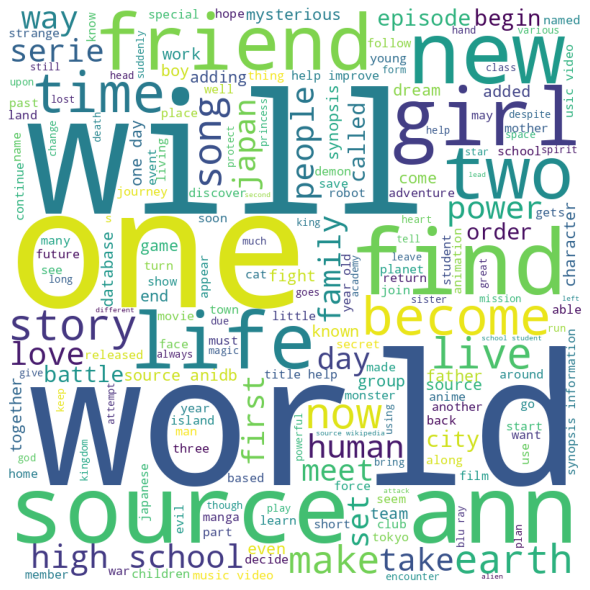

In [ ]:
# Python program to generate WordCloud

# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in anime_with_synopsis['sypnopsis']:
	
	# typecaste each val to string
	val = str(val)

	# split the value
	tokens = val.split()
	
	# Converts each token into lowercase
	for i in range(len(tokens)):
		tokens[i] = tokens[i].lower()
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				stopwords = stopwords,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image					
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


In [ ]:
rating_complete.head()

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


In [ ]:

# The mean rating: 7.510788732162693
print('mean rating: ' + str(np.mean(rating_complete['rating'])))


mean rating: 7.510788732162693


In [ ]:
watching_status.head()

,status,description
0,1,Currently Watching
1,2,Completed
2,3,On Hold
3,4,Dropped
4,6,Plan to Watch


In [ ]:
print(animelist.shape)
print(anime.shape)
print(anime_with_synopsis.shape) 
print(rating_complete.shape)
print(watching_status.shape)

(109224747, 5)
(17562, 35)
(16214, 5)
(57633278, 3)
(5, 2)


In [ ]:
usage_by_col_1 = animelist.memory_usage(deep=True) # returns memory usage for each column
total_usage_1 = usage_by_col_1.sum()
mbs1 = total_usage_1 / 1e6 # convert to megabytes 
print(mbs1)

usage_by_col_2 = anime.memory_usage(deep=True) # returns memory usage for each column
total_usage_2 = usage_by_col_2.sum()
mbs2 = total_usage_2 / 1e6 # convert to megabytes 
print(mbs2)

usage_by_col_3 = anime_with_synopsis.memory_usage(deep=True) # returns memory usage for each column
total_usage_3 = usage_by_col_3.sum()
mbs3 = total_usage_3 / 1e6 # convert to megabytes 
print(mbs3)

usage_by_col_4 = rating_complete.memory_usage(deep=True) # returns memory usage for each column
total_usage_4 = usage_by_col_4.sum()
mbs4 = total_usage_4 / 1e6 # convert to megabytes 
print(mbs4)

usage_by_col_5 = watching_status.memory_usage(deep=True) # returns memory usage for each column
total_usage_5 = usage_by_col_5.sum()
mbs5 = total_usage_5 / 1e6 # convert to megabytes 
print(mbs5)

total_mbs = mbs1+mbs2+mbs3+mbs4+mbs5
print(total_mbs)

4368.990008
32.686894
12.491762
1383.1988
0.000507
5797.367971


In [ ]:
print(animelist.isnull().any())
print(anime.isnull().any())
print(anime_with_synopsis.isnull().any())
print(rating_complete.isnull().any())
print(watching_status.isnull().any())

user_id             False
anime_id            False
rating              False
watching_status     False
watched_episodes    False
dtype: bool
MAL_ID           False
Name             False
Score            False
Genres           False
English name     False
Japanese name    False
Type             False
Episodes         False
Aired            False
Premiered        False
Producers        False
Licensors        False
Studios          False
Source           False
Duration         False
Rating           False
Ranked           False
Popularity       False
Members          False
Favorites        False
Watching         False
Completed        False
On-Hold          False
Dropped          False
Plan to Watch    False
Score-10         False
Score-9          False
Score-8          False
Score-7          False
Score-6          False
Score-5          False
Score-4          False
Score-3          False
Score-2          False
Score-1          False
dtype: bool
MAL_ID       False
Name         False
Sco

In [ ]:



for col in anime_with_synopsis.columns:  # iterate over all columns
  if anime_with_synopsis[col].dtype not in [np.int64, np.float64]:  # ignore integer and float columns
    # print a header, all unique values, and a separator
    print('Unique Values for {}'.format(col))  
    print(anime_with_synopsis[col].unique())   
    print('')

for col in rating_complete.columns:  # iterate over all columns
  if rating_complete[col].dtype not in [np.int64, np.float64]:  # ignore integer and float columns
    # print a header, all unique values, and a separator
    print('Unique Values for {}'.format(col))  
    print(rating_complete[col].unique())   
    print('')

for col in watching_status.columns:  # iterate over all columns
  # if watching_status[col].dtype not in [np.int64, np.float64]:  # ignore integer and float columns
    # print a header, all unique values, and a separator
    print('Unique Values for {}'.format(col))  
    print(watching_status[col].unique())   
    print('')

Unique Values for user_id
[     0      1      2 ... 353402 353403 353404]

Unique Values for anime_id
[   67  6702   242 ... 48480 48427 44376]

Unique Values for rating
[ 9  7 10  0  8  6  5  4  3  2  1]

Unique Values for watching_status
[ 1  2  3  4  6  0  5 33 55]

Unique Values for watched_episodes
[   1    4    0 ... 1266 1039 6688]

Unique Values for Name
['Cowboy Bebop' 'Cowboy Bebop: Tengoku no Tobira' 'Trigun' ...
 'Higurashi no Naku Koro ni Sotsu' 'Yama no Susume: Next Summit'
 'Scarlet Nexus']

Unique Values for Score
['8.78' '8.39' '8.24' '7.27' '6.98' '7.95' '8.06' '7.59' '8.15' '8.76'
 '7.91' '8.52' '7.9' '6.38' '7.94' '7.42' '7.76' '7.32' '7.51' '8.32'
 '7.45' '8.51' '8.49' '8.29' '8.73' '8.31' '7.56' '8.17' '7.35' '6.31'
 '7.26' '7.14' '7.1' '6.53' '5.91' '7.05' '7.43' '7.66' '7.2' '6.77'
 '6.62' '7.44' '7.65' '7.98' '7.58' '7.38' '6.35' '8.07' '7.96' '7.3'
 '7.99' '7.09' '7.78' '8.03' '6.79' '7.92' '6.66' '7.68' '6.67' '6.76'
 '7.72' '7.79' '7.22' '7.7' '7.82' '7.46' 

In [ ]:
import sqlite3

conn = sqlite3.connect('anime.db')
print("Opened database successfully");

conn.execute('''
CREATE TABLE IF NOT EXISTS team_data(team text, 
                      country text, 
                      season integer, 
                      total_goals integer);''')

conn.commit()

print("Table created successfully");

conn.close()

/bin/bash: conda: command not found


In [ ]:
%%spark

# Create SQL-accesible table
food_reviews_sdf.createOrReplaceTempView("food_reviews")

# Declare SQL query to be excecuted
query = '''SELECT * 
           FROM food_reviews ORDER BY `asin` DESC LIMIT 10'''

# Save the output sdf of spark.sql() as answer_review_sdf and convert to Pandas
answer_review_sdf = spark.sql(query)
answer_review_sdf.show()

In [ ]:
animelist
anime
anime_with_synopsis 
rating_complete
watching_status